# Import Libraries

In [3]:
# !pip install catboost

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns






from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    RobustScaler,
)

from sklearn.metrics import mean_absolute_error, mean_squared_error




import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
df = pd.read_csv("/kaggle/input/last-try/cleaned_train.csv")
Test = pd.read_csv("/kaggle/input/last-try/cleaned_Test.csv")

In [6]:
# df.drop(columns='order_brand', inplace=True)
# Test.drop(columns='order_brand', inplace=True)

# Splitting

In [7]:
X_train, y_train = df.drop(columns='cost'), df['cost']
id_test = Test['ID']
Test.drop(columns='ID', inplace=True)
df_test = Test.copy()

# preprocessing

## skewness

In [8]:
df.columns

Index(['grossWeight', 'netWeight', 'isRecyclable?', 'storeKind', 'storeSales',
       'storeCost', 'groceryArea', 'frozenArea', 'meatArea', 'cost',
       'customer_state', 'seller_state', 'review_score', 'totalArea',
       'packageWeight', 'item', 'department', 'count_additional_features',
       'marital_status', 'gender', 'promoCategory', 'distance_km',
       'delivery_category'],
      dtype='object')

In [9]:
numerical_cols = [
                  # 'min.YearlyIncome', 
                  'grossWeight', 
                  'netWeight', 
                  'storeSales', 
                  'storeCost', 
                  'groceryArea', 
                  'frozenArea',
                  'meatArea', 
                  'totalArea', 
                  'packageWeight',
                  'distance_km',
                 ]

categorical_cols = ['isRecyclable?', 'storeKind', 'customer_state', 'seller_state', 'review_score', 
                    'item', 
                    'department',
                    # 'order_brand',
                    'count_additional_features', 'marital_status', 'gender', 'delivery_category',
                    'promoCategory',]

In [10]:
def detect_skewness(dataframe, threshold=0.5):
    """
    Detects left or right skewed columns in a pandas DataFrame.

    Parameters:
    dataframe (pandas DataFrame): The DataFrame to analyze.
    threshold (float): The threshold for considering a column as skewed.
                      Default is 0.5.

    Returns:
    skewed_columns (list): A list of column names that are skewed.
    """
    skewed_columns = []

    for column in dataframe.columns:
        skewness = dataframe[column].skew()
        if abs(skewness) > threshold:
            skewed_columns.append((column, skewness))

    return skewed_columns

In [11]:
skewed_cols = detect_skewness(X_train[numerical_cols])
print("Skewed columns:", skewed_cols)

Skewed columns: [('storeSales', 0.6868211303463595), ('storeCost', 0.8201873236356951), ('frozenArea', 0.5616635225960148), ('meatArea', 0.5614878456048813), ('distance_km', 1.7844185462801887)]


## custom Transformer

In [12]:
class StandardScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [13]:
class RobustScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = RobustScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = RobustScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [14]:
class DataFrameImputer(TransformerMixin, BaseEstimator):
    """
    A class to impute missing values in a Pandas DataFrame using a combination of median, knn, and most frequent
    imputers on specified columns.

    Parameters:
    -----------
    median_cols : list of str, optional (default=None)
        Columns to impute missing values using the median imputer.
    knn_cols : list of str, optional (default=None)
        Columns to impute missing values using the KNN imputer.
    freq_cols : list of str, optional (default=None)
        Columns to impute missing values using the most frequent imputer.
    const_cols : dict of {column_name: constant_value} pairs, optional (default=None)
        Columns to impute missing values using a constant value.

    Returns:
    --------
    X_imputed : pandas.DataFrame
        A DataFrame with imputed missing values.
    """
    def __init__(self, median_cols=None, knn_cols=None, freq_cols=None, const_cols=None, fill_const=0):
        self.median_cols = median_cols
        self.knn_cols = knn_cols
        self.freq_cols = freq_cols
        self.const_cols = const_cols
        self.fill_const = fill_const

    def fit(self, X, y=None):
        self.median_imputer = SimpleImputer(strategy='median')
        self.knn_imputer = KNNImputer()
        self.freq_imputer = SimpleImputer(strategy='most_frequent')
        self.const_imputer = SimpleImputer(strategy='constant', fill_value=self.fill_const)

        if self.median_cols is not None:
            self.median_imputer.fit(X[self.median_cols])
        if self.knn_cols is not None:
            self.knn_imputer.fit(X[self.knn_cols])
        if self.freq_cols is not None:
            self.freq_imputer.fit(X[self.freq_cols])
        if self.const_cols is not None:
            self.const_imputer.fit(X[self.const_cols])

        return self

    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols is not None:
            X_median = pd.DataFrame(self.median_imputer.transform(X[self.median_cols]),
                                    columns=self.median_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.median_cols, axis=1), X_median], axis=1)
        if self.knn_cols is not None:
            X_knn = pd.DataFrame(self.knn_imputer.transform(X[self.knn_cols]),
                                 columns=self.knn_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.knn_cols, axis=1), X_knn], axis=1)
        if self.freq_cols is not None:
            X_freq = pd.DataFrame(self.freq_imputer.transform(X[self.freq_cols]),
                                  columns=self.freq_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.freq_cols, axis=1), X_freq], axis=1)
        if self.const_cols is not None:
            X_const = pd.DataFrame(self.const_imputer.transform(X[self.const_cols]),
                                  columns=self.const_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.const_cols, axis=1), X_const], axis=1)
        return X_imputed

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [15]:
class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, q1=0.25, q3=0.75):
        self.column = column
        self.q1 = q1
        self.q3 = q3
    def outlier_threshhold(self, dataframe, column):
        Q1 = dataframe[column].quantile(self.q1)
        Q3 = dataframe[column].quantile(self.q3)
        iqr = Q3 - Q1
        up_limit = Q3 + 1.5 * iqr
        low_limit = Q1 - 1.5 * iqr
        return low_limit, up_limit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.column:
            low_limit, up_limit = self.outlier_threshhold(X_copy, col)
            X_copy.loc[(X_copy[col] < low_limit), col] = low_limit
            X_copy.loc[(X_copy[col] > up_limit), col] = up_limit
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [16]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to be dropped.
    return
    ------
        dataframe with dropped columns
    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(self.columns,axis=1)

In [17]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    Custom OneHotEncoder with safe handling of unseen categories.
    - Creates "Other" column for unseen values.
    - Converts float integers (e.g., 1.0) into int names (1).
    """

    def __init__(self, columns=None):
        self.columns = columns
        self.unique_values = {}
        self.feature_names_ = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist()

        self.unique_values = {}
        for col in self.columns:
            # unique categories from training
            self.unique_values[col] = list(pd.Series(X[col].dropna().unique()))

        self.feature_names_ = self._get_feature_names()
        return self

    def _clean_value(self, value):
        # Convert float like 1.0 -> 1 for column names
        if isinstance(value, float) and value.is_integer():
            return int(value)
        return value

    def _get_feature_names(self):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{self._clean_value(value)}")
            feature_names.append(f"{col}_Other")  # Add 'Other' for unseen values
        return feature_names

    def transform(self, X):
        X_transformed = pd.DataFrame(index=X.index)

        for col in self.columns:
            seen_values = self.unique_values[col]

            # one-hot for known categories
            for value in seen_values:
                col_name = f"{col}_{self._clean_value(value)}"
                X_transformed[col_name] = (X[col] == value).astype(int)

            # 'Other' column = 1 if unseen category
            X_transformed[f"{col}_Other"] = ~X[col].isin(seen_values)
            X_transformed[f"{col}_Other"] = X_transformed[f"{col}_Other"].astype(int)

        # concat with original (optional, you can drop original cols if not needed)
        X_out = pd.concat([X.drop(columns=self.columns), X_transformed], axis=1)
        return X_out

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [18]:
class LabelEncodeColumns(BaseEstimator, TransformerMixin):
    """
    A transformer class to encode categorical columns using LabelEncoder.

    Parameters
    ----------
    columns : list of str
        The names of the columns to be encoded.

    return
    ------
        encoded feature
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoders_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, encoder in self.encoders_.items():
            X_copy[col] = encoder.transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [19]:
class LogTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply a log transform to a specified column in a Pandas DataFrame.

    Parameters
    ----------
    columns : str
        The name of the column to apply the log transform to.
    domain_shift : float
        The value to be added to the column before applying the log transform.

    return
    ------
        transformed feature
    """
    def __init__(self, columns, domain_shift=0):
        self.columns = columns
        self.domain_shift = domain_shift

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = np.log(X_copy[self.columns] + self.domain_shift)
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

## pipeline

In [20]:
OHE_cols = ['isRecyclable?', 'storeKind', 'customer_state', 'seller_state', 'item', 
            'department',
            # 'order_brand',
            'marital_status', 'gender', 'promoCategory', 'delivery_category']

MLE_cols = ['count_additional_features', 'review_score',]

In [21]:
preprocess_pipeline = Pipeline([
            ('impute_cat', DataFrameImputer(freq_cols=categorical_cols)),
            ('impute_num', DataFrameImputer(knn_cols=numerical_cols)),
            ('log_transformer', LogTransform(columns=numerical_cols)),
            ('label_encode', LabelEncodeColumns(columns=MLE_cols)),
            ('one_hot_encode', CustomOneHotEncoder(columns=OHE_cols)),
            ('remove_outlier', OutlierThresholdTransformer(column=numerical_cols)),
            ('Robust_scale', RobustScaleTransform(cols=numerical_cols)),
            ])

In [22]:
preprocessed_X_train = preprocess_pipeline.fit_transform(X_train)
preprocessed_df_test = preprocess_pipeline.transform(df_test)

In [23]:
model = RandomForestRegressor(random_state=42)
model.fit(preprocessed_X_train, y_train)

feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': preprocessed_X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [24]:
feature_importance_df


,Feature,Importance
9,totalArea,0.096
6,groceryArea,0.085
11,distance_km,0.074
8,meatArea,0.073
5,storeCost,0.069
4,storeSales,0.065
2,grossWeight,0.055
3,netWeight,0.054
10,packageWeight,0.034
7,frozenArea,0.024


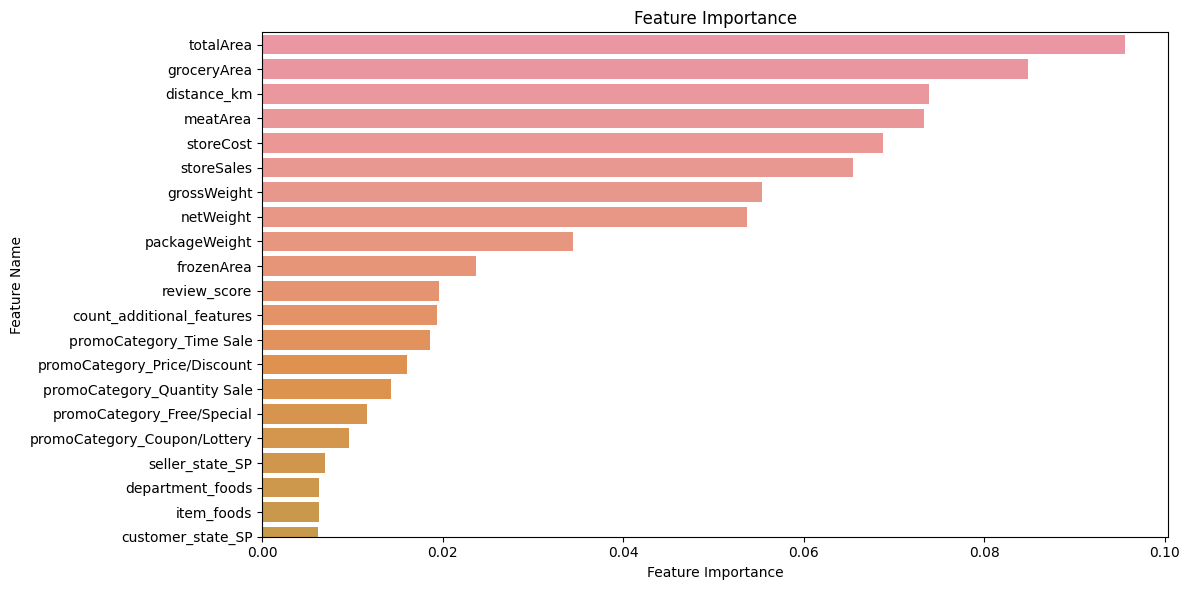

In [25]:
plt.figure(figsize=(12, 6))
fig = sns.barplot(
    y='Feature',
    x='Importance',
    data=feature_importance_df,
)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')

fig.set_ylim(20)
plt.tight_layout()

# Modeling 2 without order_brand

In [26]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(preprocessed_X_train, y_train, test_size=0.2, random_state=42)

In [27]:
model_name = []
train_rmse = []
test_rmse = []

models = [
    SVR(),
    LinearRegression(),
    GradientBoostingRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

for model in models:
    model.fit(X_train_2, y_train_2)
    y_pred = model.predict(X_test_2)
    y_train_pred = model.predict(X_train_2)
    model_name.append(model.__class__.__name__)
    train_rmse.append(np.sqrt(mean_squared_error(y_train_2, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test_2, y_pred)))


In [28]:
models_df = pd.DataFrame({
    "Model-Name": model_name,
    'Train-RMSE': train_rmse,
    'Test-RMSE': test_rmse
})

models_df = models_df.astype({"Train-RMSE": float, "Test-RMSE": float})
models_df.sort_values("Test-RMSE", ascending=True)

,Model-Name,Train-RMSE,Test-RMSE
3,RandomForestRegressor,51.212,135.948
9,CatBoostRegressor,125.705,140.459
4,ExtraTreesRegressor,0.000,140.763
7,XGBRegressor,117.160,141.385
8,XGBRFRegressor,141.933,142.668
2,GradientBoostingRegressor,143.891,145.468
5,AdaBoostRegressor,150.992,151.324
1,LinearRegression,152.746,153.725
0,SVR,153.980,155.164
6,DecisionTreeRegressor,0.000,186.781


In [29]:
rf = RandomForestRegressor(random_state=42)

# define param grid
param_dist2 = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_random2 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist2,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [30]:
rf_random2.fit(X_train_2, y_train_2)

# best params
print("Best Parameters:", rf_random2.best_params_)

# evaluate
best_rf2 = rf_random2.best_estimator_

y_pred_best2 = best_rf2.predict(X_test_2)
rmse = np.sqrt(mean_squared_error(y_test_2, y_pred_best2))
print("Best RandomForest Test RMSE:", rmse)

train_pred_2 = best_rf2.predict(X_train_2)
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, train_pred_2))
print("Best RandomForest Train RMSE:", train_rmse_2)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30}
Best RandomForest Test RMSE: 135.6556659090241
Best RandomForest Train RMSE: 63.37430919487491


In [31]:
best_params2 = rf_random2.best_params_
final_model2 = RandomForestRegressor(random_state=42, **best_params2)
final_model2.fit(preprocessed_X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='auto', min_samples_split=5,
                      n_estimators=1000, random_state=42)

In [32]:
X_sub = preprocessed_df_test
id = id_test

y_sub2 = final_model2.predict(X_sub)

id_data = pd.DataFrame(id)
id_data.columns.name = 'id'
ids = id_data.values
sub2 = np.concatenate((ids, y_sub2.reshape(-1, 1)), axis=1)
df_sub2 = pd.DataFrame(sub2, columns=['id', 'cost'])
df_sub2['id'] = df_sub2['id'].astype('int32')
df_sub2.head()

,id,cost
0,0,534.387
1,1,458.477
2,2,534.380
3,3,448.455
4,4,562.371


In [33]:
df_sub2.to_csv('submission2.csv', index=False)

## catboost

In [34]:

# Example: initialize CatBoost regressor
cat_model = CatBoostRegressor(
    verbose=0,         # to suppress training output
    random_state=42
)

# Define parameter grid for random search
param_dist = {
    'iterations': [200, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 64, 128, 254]
}

# Random search
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,          # number of parameter settings sampled
    scoring='neg_mean_squared_error',  # or another metric
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit on your training data
random_search.fit(preprocessed_X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best CV score: ", np.sqrt(-random_search.best_score_))  # convert back to positive MSE

# Best estimator
best_cat = random_search.best_estimator_


Best parameters found:  {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 10, 'border_count': 32, 'bagging_temperature': 1.0}
Best CV score:  139.41258618068505


In [35]:
final_cat = CatBoostRegressor(random_state=42, **random_search.best_params_)
final_cat.fit(preprocessed_X_train, y_train)

0:	learn: 155.9943876	total: 16.2ms	remaining: 16.2s
1:	learn: 155.7210700	total: 32.8ms	remaining: 16.4s
2:	learn: 155.4661329	total: 48.5ms	remaining: 16.1s
3:	learn: 155.2001781	total: 63.4ms	remaining: 15.8s
4:	learn: 154.9334498	total: 79ms	remaining: 15.7s
5:	learn: 154.6686143	total: 93.5ms	remaining: 15.5s
6:	learn: 154.4002714	total: 108ms	remaining: 15.4s
7:	learn: 154.1651105	total: 123ms	remaining: 15.3s
8:	learn: 153.9250036	total: 138ms	remaining: 15.2s
9:	learn: 153.6873497	total: 153ms	remaining: 15.2s
10:	learn: 153.4684259	total: 169ms	remaining: 15.2s
11:	learn: 153.2359601	total: 185ms	remaining: 15.2s
12:	learn: 153.0142514	total: 200ms	remaining: 15.2s
13:	learn: 152.8004521	total: 215ms	remaining: 15.1s
14:	learn: 152.5918852	total: 231ms	remaining: 15.2s
15:	learn: 152.3619987	total: 247ms	remaining: 15.2s
16:	learn: 152.1435627	total: 262ms	remaining: 15.2s
17:	learn: 151.9408594	total: 277ms	remaining: 15.1s
18:	learn: 151.7324820	total: 291ms	remaining: 15s
1

In [36]:
from sklearn.ensemble import VotingRegressor
# Voting Regressor
voting = VotingRegressor([
    ('rf', final_model2),
    ('cat', final_cat)
])


voting.fit(X_train_2, y_train_2)
voting_pred = voting.predict(X_test_2)
voting_score = np.sqrt(mean_squared_error(y_test_2, voting_pred))
print(f'Voting Regressor RMSE: {voting_score}')

0:	learn: 156.0341793	total: 17ms	remaining: 17s
1:	learn: 155.7464748	total: 31.2ms	remaining: 15.6s
2:	learn: 155.4963683	total: 43.6ms	remaining: 14.5s
3:	learn: 155.2359240	total: 56.8ms	remaining: 14.2s
4:	learn: 154.9865767	total: 69.1ms	remaining: 13.8s
5:	learn: 154.7223280	total: 81.6ms	remaining: 13.5s
6:	learn: 154.4651641	total: 95.1ms	remaining: 13.5s
7:	learn: 154.2087258	total: 108ms	remaining: 13.4s
8:	learn: 154.0215411	total: 121ms	remaining: 13.3s
9:	learn: 153.8013138	total: 133ms	remaining: 13.2s
10:	learn: 153.5802558	total: 146ms	remaining: 13.1s
11:	learn: 153.3579166	total: 158ms	remaining: 13s
12:	learn: 153.1369806	total: 171ms	remaining: 13s
13:	learn: 152.9257871	total: 183ms	remaining: 12.9s
14:	learn: 152.7028388	total: 196ms	remaining: 12.9s
15:	learn: 152.4801346	total: 209ms	remaining: 12.9s
16:	learn: 152.2593977	total: 223ms	remaining: 12.9s
17:	learn: 152.0540329	total: 236ms	remaining: 12.9s
18:	learn: 151.8523721	total: 251ms	remaining: 13s
19:	le

In [37]:
voting_train_pred = voting.predict(X_train_2)
print(f'Voting Regressor RMSE: {np.sqrt(mean_squared_error(y_train_2, voting_train_pred))}')

Voting Regressor RMSE: 95.04248036434763


## voting and stacking

In [38]:
# et = ExtraTreesRegressor(n_estimators = 140, random_state=42)
# et.fit(X_train_2, y_train_2)

# et_pred = et.predict(X_test_2) 
# et_score = np.sqrt(mean_squared_error(y_test_2, et_pred))
# print(f'Extra Trees RMSE: {et_score}')

# Extra Trees RMSE: 145.02118638682492

In [39]:
# from sklearn.ensemble import VotingRegressor
# # Voting Regressor
# voting = VotingRegressor([
#     ('rf', final_model2),
#     ('et', et)
# ])


# voting.fit(X_train_2, y_train_2)
# voting_pred = voting.predict(X_test_2)
# voting_score = np.sqrt(mean_squared_error(y_test_2, voting_pred))
# print(f'Voting Regressor RMSE: {voting_score}')

# Voting Regressor RMSE: 139.06516301153172

In [40]:
# voting_train_pred = voting.predict(X_train_2)
# print(f'Voting Regressor RMSE: {np.sqrt(mean_squared_error(y_train_2, voting_train_pred))}')

# Voting Regressor RMSE: 33.501876362251046

In [41]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
# stacking

# Extra Trees
et = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

dt = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_lambda=1,
    random_state=42,
    verbosity=0
)

xgbrf = XGBRFRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bynode=0.8,
    reg_lambda=1,
    random_state=42,
    verbosity=0,
    n_jobs=-1
)

cb = final_cat

lgb = LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_lambda=1,
    random_state=42,
    verbose=-1
)

# Bagging
bag = BaggingRegressor(
    n_estimators=300,
    max_samples=0.8,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

# AdaBoost
ada = AdaBoostRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

stacking = StackingRegressor(
    estimators=[
        ('voiting', voting),
        ('rf', final_model2),
        ('et', et),
        ('dt', dt),
        ('xgb', xgb),
        ('xgbrf', xgbrf),
        ('cb', cb),
        ('lgb', lgb),
        ('bag', bag),
        ('gb', gb),
        ('ada', ada)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)


stacking.fit(X_train_2, y_train_2)




/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0:	learn: 156.0341793	total: 131ms	remaining: 2m 10s
1:	learn: 155.7464748	total: 188ms	remaining: 1m 33s
2:	learn: 155.4963683	total: 250ms	remaining: 1m 23s
3:	learn: 155.2359240	total: 317ms	remaining: 1m 18s
4:	learn: 154.9865767	total: 351ms	remaining: 1m 9s
5:	learn: 154.7223280	total: 393ms	remaining: 1m 5s
6:	learn: 154.4651641	total: 425ms	remaining: 1m
7:	learn: 154.2087258	total: 462ms	remaining: 57.3s
8:	learn: 154.0215411	total: 498ms	remaining: 54.9s
9:	learn: 153.8013138	total: 557ms	remaining: 55.1s
10:	learn: 153.5802558	total: 597ms	remaining: 53.6s
11:	learn: 153.3579166	total: 633ms	remaining: 52.1s
12:	learn: 153.1369806	total: 668ms	remaining: 50.8s
13:	learn: 152.9257871	total: 707ms	remaining: 49.8s
14:	learn: 152.7028388	total: 735ms	remaining: 48.3s
15:	learn: 152.4801346	total: 773ms	remaining: 47.6s
16:	learn: 152.2593977	total: 813ms	remaining: 47s
17:	learn: 152.0540329	total: 851ms	remaining: 46.4s
18:	learn: 151.8523721	total: 893ms	remaining: 46.1s
19:	

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

0:	learn: 155.9712762	total: 181ms	remaining: 3m 1s
0:	learn: 156.0183574	total: 184ms	remaining: 3m 3s
0:	learn: 155.7491297	total: 133ms	remaining: 2m 12s
1:	learn: 155.7109709	total: 285ms	remaining: 2m 22s
1:	learn: 155.7210350	total: 291ms	remaining: 2m 25s
0:	learn: 155.9161660	total: 115ms	remaining: 1m 55s
2:	learn: 155.4514855	total: 366ms	remaining: 2m 1s
1:	learn: 155.4762139	total: 252ms	remaining: 2m 5s
1:	learn: 155.6478393	total: 246ms	remaining: 2m 2s
2:	learn: 155.4563987	total: 444ms	remaining: 2m 27s
3:	learn: 155.1869216	total: 483ms	remaining: 2m
2:	learn: 155.2271110	total: 361ms	remaining: 1m 59s
4:	learn: 154.9210493	total: 576ms	remaining: 1m 54s
3:	learn: 155.0154287	total: 451ms	remaining: 1m 52s
2:	learn: 155.3866850	total: 354ms	remaining: 1m 57s
3:	learn: 155.1997582	total: 566ms	remaining: 2m 20s
4:	learn: 154.7457528	total: 542ms	remaining: 1m 47s
5:	learn: 154.6542045	total: 688ms	remaining: 1m 54s
3:	learn: 155.1731160	total: 458ms	remaining: 1m 54s
4:

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


84:	learn: 144.3298249	total: 5.18s	remaining: 55.7s
120:	learn: 142.2123618	total: 6.86s	remaining: 49.8s
85:	learn: 144.2496121	total: 5.25s	remaining: 55.7s
25:	learn: 150.4690673	total: 1.76s	remaining: 1m 5s
121:	learn: 142.1825583	total: 6.91s	remaining: 49.7s
122:	learn: 142.1540283	total: 6.99s	remaining: 49.8s
26:	learn: 150.3173799	total: 1.83s	remaining: 1m 6s
86:	learn: 144.1962791	total: 5.33s	remaining: 55.9s
27:	learn: 150.1621458	total: 1.9s	remaining: 1m 6s
87:	learn: 144.1421459	total: 5.4s	remaining: 55.9s
123:	learn: 142.0955355	total: 7.07s	remaining: 49.9s
88:	learn: 144.0879535	total: 5.45s	remaining: 55.8s
124:	learn: 142.0514091	total: 7.13s	remaining: 49.9s
28:	learn: 150.0384671	total: 2s	remaining: 1m 6s
125:	learn: 142.0170410	total: 7.2s	remaining: 50s
89:	learn: 144.0283379	total: 5.54s	remaining: 56s
29:	learn: 149.8829154	total: 2.09s	remaining: 1m 7s
30:	learn: 149.7272298	total: 2.13s	remaining: 1m 6s
90:	learn: 143.9844007	total: 5.62s	remaining: 56.

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


835:	learn: 128.5399617	total: 39.4s	remaining: 7.72s
966:	learn: 126.6678915	total: 44.5s	remaining: 1.52s
745:	learn: 130.0430674	total: 35s	remaining: 11.9s
901:	learn: 127.8807559	total: 42.9s	remaining: 4.66s
967:	learn: 126.6431608	total: 44.6s	remaining: 1.47s
836:	learn: 128.5216469	total: 39.4s	remaining: 7.68s
746:	learn: 130.0215032	total: 35.1s	remaining: 11.9s
902:	learn: 127.8682736	total: 43s	remaining: 4.62s
837:	learn: 128.5034283	total: 39.5s	remaining: 7.63s
903:	learn: 127.8511161	total: 43s	remaining: 4.57s
747:	learn: 130.0055337	total: 35.1s	remaining: 11.8s
968:	learn: 126.6215199	total: 44.6s	remaining: 1.43s
838:	learn: 128.4889225	total: 39.5s	remaining: 7.58s
969:	learn: 126.6079243	total: 44.7s	remaining: 1.38s
904:	learn: 127.8363338	total: 43.1s	remaining: 4.52s
748:	learn: 129.9970320	total: 35.2s	remaining: 11.8s
905:	learn: 127.8158108	total: 43.1s	remaining: 4.47s
749:	learn: 129.9879829	total: 35.2s	remaining: 11.7s
970:	learn: 126.5966253	total: 44.

StackingRegressor(cv=5,
                  estimators=[('voiting',
                               VotingRegressor(estimators=[('rf',
                                                            RandomForestRegressor(max_depth=30,
                                                                                  max_features='auto',
                                                                                  min_samples_split=5,
                                                                                  n_estimators=1000,
                                                                                  random_state=42)),
                                                           ('cat',
                                                            <catboost.core.CatBoostRegressor object at 0x7de14110d110>)])),
                              ('rf',
                               RandomForestRegressor(max_depth=30,
                                                     max_features='auto',
                                                     min_samples_split=5,
                                                     n_estimator...
                                             reg_lambda=1, subsample=0.8,
                                             verbose=-1)),
                              ('bag',
                               BaggingRegressor(max_features=0.8,
                                                max_samples=0.8,
                                                n_estimators=300, n_jobs=-1,
                                                random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         min_samples_leaf=10,
                                                         n_estimators=800,
                                                         random_state=42)),
                              ('ada',
                               AdaBoostRegressor(learning_rate=0.05,
                                                 n_estimators=500,
                                                 random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

In [42]:
stacking_pred2 = stacking.predict(X_test_2)
stacking_score2 = np.sqrt(mean_squared_error(y_test_2, stacking_pred2))
print(f'Stacking Regressor RMSE: {stacking_score2}')

Stacking Regressor RMSE: 135.39828054401235


In [43]:
stacking_train_pred = stacking.predict(X_train_2)
print(f'Stacking Regressor RMSE: {np.sqrt(mean_squared_error(y_train_2, stacking_train_pred))}')

Stacking Regressor RMSE: 74.01661505029182


In [44]:
stacking.fit(preprocessed_X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0:	learn: 155.9943876	total: 119ms	remaining: 1m 59s
1:	learn: 155.7210700	total: 158ms	remaining: 1m 18s
2:	learn: 155.4661329	total: 197ms	remaining: 1m 5s
3:	learn: 155.2001781	total: 247ms	remaining: 1m 1s
4:	learn: 154.9334498	total: 291ms	remaining: 57.9s
5:	learn: 154.6686143	total: 329ms	remaining: 54.4s
6:	learn: 154.4002714	total: 366ms	remaining: 51.9s
7:	learn: 154.1651105	total: 409ms	remaining: 50.7s
8:	learn: 153.9250036	total: 453ms	remaining: 49.9s
9:	learn: 153.6873497	total: 493ms	remaining: 48.8s
10:	learn: 153.4684259	total: 535ms	remaining: 48.1s
11:	learn: 153.2359601	total: 573ms	remaining: 47.2s
12:	learn: 153.0142514	total: 618ms	remaining: 46.9s
13:	learn: 152.8004521	total: 657ms	remaining: 46.3s
14:	learn: 152.5918852	total: 734ms	remaining: 48.2s
15:	learn: 152.3619987	total: 800ms	remaining: 49.2s
16:	learn: 152.1435627	total: 846ms	remaining: 48.9s
17:	learn: 151.9408594	total: 894ms	remaining: 48.8s
18:	learn: 151.7324820	total: 935ms	remaining: 48.3s
1

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

0:	learn: 156.1021812	total: 245ms	remaining: 4m 4s
1:	learn: 155.8055309	total: 420ms	remaining: 3m 29s
0:	learn: 155.8014929	total: 104ms	remaining: 1m 44s
2:	learn: 155.5434879	total: 561ms	remaining: 3m 6s
0:	learn: 155.9912504	total: 162ms	remaining: 2m 42s
1:	learn: 155.5380170	total: 234ms	remaining: 1m 56s
3:	learn: 155.3319948	total: 689ms	remaining: 2m 51s
0:	learn: 156.4453600	total: 130ms	remaining: 2m 9s
1:	learn: 155.7232767	total: 346ms	remaining: 2m 52s
4:	learn: 155.0730090	total: 816ms	remaining: 2m 42s
2:	learn: 155.2824885	total: 401ms	remaining: 2m 13s
1:	learn: 156.1848991	total: 242ms	remaining: 2m
2:	learn: 155.4743075	total: 416ms	remaining: 2m 18s
5:	learn: 154.8108735	total: 941ms	remaining: 2m 35s
3:	learn: 155.0246722	total: 510ms	remaining: 2m 6s
2:	learn: 155.9369741	total: 367ms	remaining: 2m 1s
3:	learn: 155.2101983	total: 562ms	remaining: 2m 19s
4:	learn: 154.7687518	total: 617ms	remaining: 2m 2s
6:	learn: 154.5590827	total: 1.07s	remaining: 2m 31s
3:	

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


308:	learn: 137.8803989	total: 16.1s	remaining: 35.9s
309:	learn: 137.8681189	total: 16.1s	remaining: 35.9s
310:	learn: 137.8498860	total: 16.2s	remaining: 35.8s
311:	learn: 137.8265942	total: 16.2s	remaining: 35.8s
312:	learn: 137.8136061	total: 16.3s	remaining: 35.8s
313:	learn: 137.7790041	total: 16.3s	remaining: 35.7s
314:	learn: 137.7629326	total: 16.4s	remaining: 35.7s
315:	learn: 137.7439772	total: 16.5s	remaining: 35.7s
316:	learn: 137.7249937	total: 16.5s	remaining: 35.6s
317:	learn: 137.7139795	total: 16.6s	remaining: 35.6s
318:	learn: 137.6917203	total: 16.7s	remaining: 35.6s
319:	learn: 137.6809614	total: 16.7s	remaining: 35.5s
320:	learn: 137.6646084	total: 16.8s	remaining: 35.5s
321:	learn: 137.6515868	total: 16.8s	remaining: 35.5s
322:	learn: 137.6353210	total: 16.9s	remaining: 35.5s
323:	learn: 137.6184628	total: 17s	remaining: 35.5s
324:	learn: 137.6072277	total: 17.1s	remaining: 35.4s
325:	learn: 137.5920790	total: 17.2s	remaining: 35.5s
326:	learn: 137.5803486	total:

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


587:	learn: 134.0783756	total: 28.3s	remaining: 19.8s
999:	learn: 128.1365324	total: 48.3s	remaining: 0us
611:	learn: 132.9745615	total: 29.2s	remaining: 18.5s
588:	learn: 134.0604264	total: 28.3s	remaining: 19.7s
566:	learn: 134.1978818	total: 27.9s	remaining: 21.3s
612:	learn: 132.9621660	total: 29.3s	remaining: 18.5s
0:	learn: 155.6909899	total: 15.5ms	remaining: 15.5s
1:	learn: 155.4223595	total: 30.9ms	remaining: 15.4s
2:	learn: 155.1520265	total: 43.4ms	remaining: 14.4s
3:	learn: 154.9023937	total: 55.1ms	remaining: 13.7s
4:	learn: 154.6692914	total: 67.1ms	remaining: 13.3s
5:	learn: 154.4275897	total: 78.8ms	remaining: 13.1s
6:	learn: 154.1553204	total: 90.4ms	remaining: 12.8s
7:	learn: 153.9365113	total: 103ms	remaining: 12.7s
8:	learn: 153.7033988	total: 115ms	remaining: 12.6s
9:	learn: 153.4669796	total: 127ms	remaining: 12.5s
10:	learn: 153.2444556	total: 139ms	remaining: 12.5s
11:	learn: 153.0025411	total: 151ms	remaining: 12.4s
12:	learn: 152.7983275	total: 163ms	remaining

StackingRegressor(cv=5,
                  estimators=[('voiting',
                               VotingRegressor(estimators=[('rf',
                                                            RandomForestRegressor(max_depth=30,
                                                                                  max_features='auto',
                                                                                  min_samples_split=5,
                                                                                  n_estimators=1000,
                                                                                  random_state=42)),
                                                           ('cat',
                                                            <catboost.core.CatBoostRegressor object at 0x7de14110d110>)])),
                              ('rf',
                               RandomForestRegressor(max_depth=30,
                                                     max_features='auto',
                                                     min_samples_split=5,
                                                     n_estimator...
                                             reg_lambda=1, subsample=0.8,
                                             verbose=-1)),
                              ('bag',
                               BaggingRegressor(max_features=0.8,
                                                max_samples=0.8,
                                                n_estimators=300, n_jobs=-1,
                                                random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=5,
                                                         min_samples_leaf=10,
                                                         n_estimators=800,
                                                         random_state=42)),
                              ('ada',
                               AdaBoostRegressor(learning_rate=0.05,
                                                 n_estimators=500,
                                                 random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

In [45]:
X_sub = preprocessed_df_test
id = id_test

y_sub3 = stacking.predict(X_sub)

id_data = pd.DataFrame(id)
id_data.columns.name = 'id'
ids = id_data.values
sub3 = np.concatenate((ids, y_sub3.reshape(-1, 1)), axis=1)
df_sub3 = pd.DataFrame(sub3, columns=['id', 'cost'])
df_sub3['id'] = df_sub3['id'].astype('int32')
df_sub3.head()

,id,cost
0,0,532.336
1,1,450.899
2,2,545.285
3,3,435.161
4,4,555.457


In [46]:
df_sub3.to_csv('submission3.csv', index=False)

## nn

In [47]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers, models
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error



SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-09-12 15:24:20.571997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757690660.943178      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757690661.049018      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [48]:
def to_numpy(X):
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        return X.values
    return np.asarray(X)

X_all = to_numpy(preprocessed_X_train)
y_all = to_numpy(y_train).reshape(-1,)

input_dim = X_all.shape[1]
print("Input dim:", input_dim, "Samples:", X_all.shape[0])

Input dim: 151 Samples: 41223


In [49]:
def build_model(input_dim,
                dense_units=[512, 256, 128, 64],
                dropout_rate=0.2,
                l2_reg=1e-4,
                gaussian_noise=1e-2,
                learning_rate=1e-3):
    inp = layers.Input(shape=(input_dim,))
    x = inp

    # small input noise for robustness
    if gaussian_noise is not None and gaussian_noise > 0:
        x = layers.GaussianNoise(gaussian_noise)(x)

    for i, units in enumerate(dense_units):
        x = layers.Dense(units,
                         kernel_regularizer=regularizers.l2(l2_reg),
                         bias_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)     # smooth nonlinearity
        # larger dropout in deeper layers
        x = layers.Dropout(dropout_rate if i < len(dense_units)-1 else dropout_rate/2)(x)

    # final
    out = layers.Dense(1, activation='linear')(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(learning_rate=learning_rate)
    # Add RMSE metric (tensorflow >=2.6 has RootMeanSquaredError)
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model




def make_tf_dataset(X, y=None, batch_size=256, shuffle=False):
    if y is None:
        ds = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
    else:
        ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [50]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

fold_scores = []
fold_models_paths = []
EPOCHS = 200
BATCH_SIZE = 256

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), 1):
    print(f"\n=== Fold {fold}/{n_splits} ===")
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train_f, y_val = y_all[train_idx], y_all[val_idx]

    model = build_model(input_dim=input_dim,
                        dense_units=[512,256,128,64],
                        dropout_rate=0.25,
                        l2_reg=1e-4,
                        gaussian_noise=0.01,
                        learning_rate=1e-3)

    # callbacks
    ckpt_path = f"nn_fold{fold}.h5"
    fold_models_paths.append(ckpt_path)

    cb = [
        callbacks.EarlyStopping(monitor='val_rmse', patience=18, verbose=1, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_rmse', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
        callbacks.ModelCheckpoint(ckpt_path, monitor='val_rmse', save_best_only=True, save_weights_only=False, verbose=1)
    ]

    # datasets
    train_ds = make_tf_dataset(X_train, y_train_f, batch_size=BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cb,
        verbose=2
    )

    # load best weights (ModelCheckpoint + EarlyStopping restore handled)
    model = models.load_model(ckpt_path, compile=True)

    # evaluate on validation fold and also compute RMSE via sklearn (consistent)
    val_preds = model.predict(X_val, batch_size=BATCH_SIZE).reshape(-1,)
    rmse = mean_squared_error(y_val, val_preds, squared=False)
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    fold_scores.append(rmse)

print("\nCV RMSE per fold:", fold_scores)
print("CV RMSE mean: {:.4f} std: {:.4f}".format(np.mean(fold_scores), np.std(fold_scores)))



=== Fold 1/5 ===


I0000 00:00:1757690678.258962      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757690678.259663      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/200


I0000 00:00:1757690685.967303    1007 service.cc:148] XLA service 0x10cd5d170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757690685.968800    1007 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757690685.968822    1007 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757690686.512495    1007 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757690690.929226    1007 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_rmse improved from inf to 536.60602, saving model to nn_fold1.h5
129/129 - 17s - 128ms/step - loss: 291450.0312 - rmse: 539.8610 - val_loss: 287946.0625 - val_rmse: 536.6060 - learning_rate: 0.0010
Epoch 2/200

Epoch 2: val_rmse improved from 536.60602 to 528.61847, saving model to nn_fold1.h5
129/129 - 1s - 4ms/step - loss: 286319.8125 - rmse: 535.0885 - val_loss: 279437.6250 - val_rmse: 528.6185 - learning_rate: 0.0010
Epoch 3/200

Epoch 3: val_rmse improved from 528.61847 to 512.41595, saving model to nn_fold1.h5
129/129 - 1s - 4ms/step - loss: 276829.4688 - rmse: 526.1458 - val_loss: 262570.2812 - val_rmse: 512.4160 - learning_rate: 0.0010
Epoch 4/200

Epoch 4: val_rmse improved from 512.41595 to 493.22403, saving model to nn_fold1.h5
129/129 - 1s - 4ms/step - loss: 261849.4531 - rmse: 511.7122 - val_loss: 243270.1094 - val_rmse: 493.2240 - learning_rate: 0.0010
Epoch 5/200

Epoch 5: val_rmse improved from 493.22403 to 472.42432, saving model to nn_fold1.h5
129/129 - 

In [51]:
def ensemble_predict(X, model_paths):
    preds = []
    for p in model_paths:
        m = models.load_model(p, compile=True)
        preds.append(m.predict(X.astype(np.float32), batch_size=256).reshape(-1,))
    return np.mean(np.vstack(preds), axis=0)

In [52]:
X_sub_np = to_numpy(preprocessed_df_test)   

sub_preds1 = ensemble_predict(X_sub_np, fold_models_paths)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [53]:
id = id_test
id_data = pd.DataFrame(id)
id_data.columns.name = 'id'
ids = id_data.values
nn_sub1 = np.concatenate((ids, sub_preds1.reshape(-1, 1)), axis=1)
df_nn_sub1 = pd.DataFrame(nn_sub1, columns=['id', 'cost'])
df_nn_sub1['id'] = df_nn_sub1['id'].astype('int32')
df_nn_sub1.head()

,id,cost
0,0,535.693
1,1,473.880
2,2,514.793
3,3,419.855
4,4,504.398


In [54]:
df_nn_sub1.to_csv('nn_submission1.csv', index=False)

In [55]:
final_model = build_model(input_dim=input_dim,
                          dense_units=[512,256,128,64],
                          dropout_rate=0.25,
                          l2_reg=1e-4,
                          gaussian_noise=0.01,
                          learning_rate=5e-4)

# full_ds = make_tf_dataset(X_all, y_all, batch_size=BATCH_SIZE, shuffle=True)
cb_final = [
    callbacks.EarlyStopping(monitor='rmse', patience=20, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='rmse', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint("nn_final.h5", monitor='rmse', save_best_only=True, save_weights_only=False, verbose=1)
]

final_model.fit(
    X_all, y_all,
    validation_split=0.1,   # 10% validation
    epochs=200,
    batch_size=BATCH_SIZE,
    callbacks=cb_final,
    verbose=2
)

Epoch 1/200

Epoch 1: rmse improved from inf to 539.59302, saving model to nn_final.h5
145/145 - 15s - 105ms/step - loss: 291160.7500 - rmse: 539.5930 - val_loss: 295202.0312 - val_rmse: 543.3248 - learning_rate: 5.0000e-04
Epoch 2/200

Epoch 2: rmse improved from 539.59302 to 537.54639, saving model to nn_final.h5
145/145 - 1s - 4ms/step - loss: 288956.1875 - rmse: 537.5464 - val_loss: 291106.7500 - val_rmse: 539.5430 - learning_rate: 5.0000e-04
Epoch 3/200

Epoch 3: rmse improved from 537.54639 to 534.98669, saving model to nn_final.h5
145/145 - 1s - 4ms/step - loss: 286210.8438 - rmse: 534.9867 - val_loss: 286988.7500 - val_rmse: 535.7132 - learning_rate: 5.0000e-04
Epoch 4/200

Epoch 4: rmse improved from 534.98669 to 531.45880, saving model to nn_final.h5
145/145 - 1s - 4ms/step - loss: 282448.5000 - rmse: 531.4588 - val_loss: 280510.1562 - val_rmse: 529.6321 - learning_rate: 5.0000e-04
Epoch 5/200

Epoch 5: rmse improved from 531.45880 to 526.56470, saving model to nn_final.h5
14

In [56]:
X_sub_np = to_numpy(preprocessed_df_test) 

sub_preds2 = final_model.predict(X_sub_np)

624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [57]:
id = id_test
id_data = pd.DataFrame(id)
id_data.columns.name = 'id'
ids = id_data.values
nn_sub2 = np.concatenate((ids, sub_preds2.reshape(-1, 1)), axis=1)
df_nn_sub2 = pd.DataFrame(nn_sub2, columns=['id', 'cost'])
df_nn_sub2['id'] = df_nn_sub1['id'].astype('int32')
df_nn_sub2.head()

,id,cost
0,0,648.276
1,1,462.246
2,2,512.046
3,3,543.971
4,4,623.797


In [58]:
df_nn_sub2.to_csv('nn_submission2.csv', index=False)